Available backends:

- c
- cuda (NVIDIA GPUs)
- hip (AMD GPUs)
- opencl (for any opencl implementation (but mainly GPUs))
- python
- pyopencl
- wasm

In [1]:
import raytrace
import matplotlib.pyplot as plt
import numpy as np

try:
    import pyopencl
    gpuSupport = True
except ModuleNotFoundError:
    gpuSupport = False

print('gpuSupport', gpuSupport)

%matplotlib inline

gpuSupport True


In [2]:
o = raytrace.raytrace()

In [3]:
%%timeit
result = o.main(5000, 5000)

12.1 ms ± 37.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit
result = o.main(5000, 5000).get()

74.7 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


(500, 500, 3) float32
<class 'pyopencl.array.Array'>


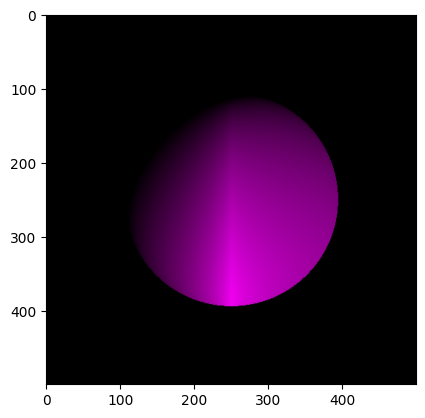

In [5]:
result = o.main(500, 500)

print(result.shape, result.dtype)
print(type(result))

if gpuSupport and isinstance(result, pyopencl.array.Array):
    image = result.get() # download opencl array from gpu
else:
    image = result # is numpy array allready

plt.imshow(image)

(500, 500, 3) float32


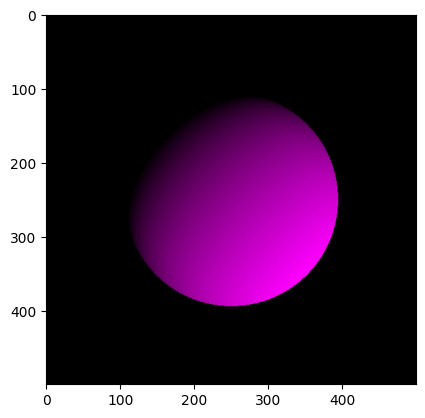

In [6]:
import numba

@numba.njit
def raytrace_np(rows, cols):
    np_image = np.zeros((rows, cols, 3), dtype=np.float32)
    ray_origin = np.array([0.0, 0.0, 1.0])
    lightDir = np.array([-1.0, -1.0, -1.0])
    lightDir = lightDir / np.linalg.norm(lightDir)
    sphere_radius = 0.5

    for n in range(rows):
        for m in range(cols):
            x = (m / cols) * 2.0 - 1.0
            y = (n / rows) * 2.0 - 1.0
            ray_direction = np.array([x, y, -1.0])
            a = np.dot(ray_direction, ray_direction)
            b = 2.0 * np.dot(ray_origin, ray_direction)
            c = np.dot(ray_origin, ray_origin) - sphere_radius * sphere_radius
            discriminant = b * b - 4.0 * a * c
            if discriminant < 0.0:
                np_image[n,m] = np.array([0, 0, 0])
            else:
                closestT = (-b - np.sqrt(discriminant)) / (2.0 * a)
                _t0 = (-b + np.sqrt(discriminant)) / (2.0 * a) # currently unused
                hitPoint = ray_origin + (ray_direction * closestT)
                normal = hitPoint / np.linalg.norm(hitPoint)
                lightIntensity = max(np.dot(normal, -lightDir), 0.0)
                np_image[n,m] = np.array([lightIntensity, 0, lightIntensity])
    
    return np_image

np_image = raytrace_np(500, 500)
print(np_image.shape, np_image.dtype)
plt.imshow(np_image)

In [7]:
%%time
result = raytrace_np(500, 500)

CPU times: user 65.5 ms, sys: 3.5 ms, total: 69 ms
Wall time: 68.7 ms


In [8]:
%%time
result = raytrace_np(5000, 5000)

CPU times: user 6.7 s, sys: 87.7 ms, total: 6.79 s
Wall time: 6.77 s
